In [1]:
import sys
sys.path.append("../src")

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

# Load dataset and do some preprocessing

In [3]:
train_path = "../data/train.csv"
df_data = pd.read_csv(train_path, sep=",")

#### Setting X

In [4]:
df_features = df_data[df_data.columns.difference(['full_label', 'label'])]
X = df_features.values
print(X.shape)

(29, 15104)


#### Setting y

In [5]:
df_labels = df_data["label"]
y = df_labels.values
print(y.shape)

(29,)


# Feature selection with LASSO

## Impact of the number of trainning iteration on sparcity

In [6]:
n_splits = 5
scores = []
sparcities = []


for k in range (2,6):

    sparcity = 0
    score = 0

    #K-Fold vor validation
    kf = KFold(n_splits=n_splits)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Trainning
        clf_l1_LR = LogisticRegression(penalty='l1', solver='saga', max_iter=10**k, multi_class='multinomial')
        clf_l1_LR.fit(X_train, y_train)

        # Inference
        predictions = clf_l1_LR.predict(X_test)
        score += clf_l1_LR.score(X_test, y_test)

        #Sparcity measurement
        coef_l1_LR = clf_l1_LR.coef_.ravel()
        sparcity += np.mean(coef_l1_LR == 0) * 100

    print("Score for 1e{} :".format(k), score/n_splits)
    print("Sparcity for 1e{} :".format(k), sparcity/n_splits)

    scores.append(score/n_splits)
    sparcities.append(sparcity/n_splits)

Score for 1e2 : 0.06666666666666667
Sparcity for 1e2 : 70.85275423728812
Score for 1e3 : 0.2733333333333333
Sparcity for 1e3 : 91.36475988700565
Score for 1e4 : 0.44000000000000006
Sparcity for 1e4 : 97.92593573446327
Score for 1e5 : 0.44000000000000006
Sparcity for 1e5 : 97.92593573446327


ValueError: x and y must have same first dimension, but have shapes (6,) and (4,)

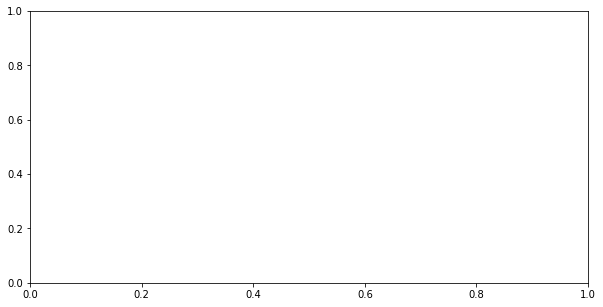

In [7]:
num_iteration = np.arange(2,8)
plt.figure(figsize=(10,5))
plt.plot(num_iteration,sparcities)
plt.xlabel("Number of iteration ($10^x$)")
plt.ylabel("Percentage of null weights")
plt.show()

# Find most relevant values

In [ ]:
clf_l1_LR = LogisticRegression(penalty='l1', solver='saga', max_iter=10000, multi_class='multinomial')
clf_l1_LR.fit(X_train, y_train)

## Extract non null weights and corresponding labels

In [ ]:
label_features_name = {}
label_features_weight = {}
for i,cat_features in enumerate(clf_l1_LR.coef_):
    relevant_features = np.where(cat_features != 0)
    label_features_name[i] = df_features.columns[relevant_features].to_list()
    label_features_weight[i] = cat_features[relevant_features]
    print("Number of relevant features for category {} :".format(i),len(relevant_features[0]))

## Sort features by weigth importance

In [ ]:
import collections
label_dictionary = {}
top_n_values = {}
top_n = 20

for i in range(3):
    d = dict(zip(label_features_name[i],label_features_weight[i]))
    label_dictionary[i] = collections.OrderedDict({k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)})
    top_n_values[i] = list(label_dictionary[i].items())[:top_n]
    

## Plot most important features for each labels

In [ ]:
for k in range(3):
    labels, value = zip(*top_n_values[k])
    plt.figure(figsize=(20,5))
    plt.bar(labels, value)

## Check how much are in the provided important features

In [ ]:
relevant_features = pd.read_csv("../data/important_genes.csv", sep=",")
relevant_features_array = relevant_features.values.flatten()

In [ ]:
label_1 = [top_100[0][k][0] for k in range(len(top_100[0]))]
label_2 = [top_100[1][k][0] for k in range(len(top_100[1]))]
label_3 = [top_100[2][k][0] for k in range(len(top_100[2]))]

shared_features = []
for gene in relevant_features_array:
    if gene in label_1+label_2+label_3:
        if gene not in shared_features:
            shared_features.append(gene)
            
print("Ratio", len(shared_features)/len(relevant_features_array))
print("Shared features \n", shared_features)